## 課題提出時（2018/12/26）の所感
word2vec/RNN/LSTM/seq2seqの全体イメージの獲得にとても時間が掛かりました・とても苦労しました。昨日（12/25）の夜にようやく全体イメージがついてきたところです。少しづつ分かってくると、CNNなどの画像技術とは別の奥深さを感じました。世の中のデータは時系列データに溢れているのでRNNを使いこなせるようになりたいと感じました。

# 1.この課題の目的

・RNNの活用例を知る  
・慣れていないフレームワークとの関わり方を知る  
【目的としないこと】  
・手法の細かい部分への理解  
・新たなフレームワークへの詳しい理解  

# 2.進め方
・実装を動かす（1日目〜2日目）  
・説明を記述する。（2日目夜発表）  

# 3.機械翻訳
### 実行

RNNの最も基本的な活用例としては機械翻訳がある。これは時系列を入力し、時系列を出力するSequence to Sequenceの手法によって行える。

https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py

Keras公式のサンプルコードで、短い英語からフランス語への変換が行えるのでこれを動かすこと。

### コードリーディング

このサンプルコードの各部分がどういった役割かを読み取り、まとめること。以下のようにどこからどこの行が何をしているかをまとめる。

（例）  
51から55行目 : ライブラリのimport  
57から62行目 : ハイパーパラメータの設定

## コードリーディング

In [1]:
'''Sequence to sequence example in Keras (character-level).

This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

# Summary of the algorithm
# アルゴリズムのまとめ

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
    
    ドメインからの入力シーケンス（例：英語の文章）から始めます。
  および他のドメインからの対応する標的配列
  （フランス語の文章など）
    
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
    エンコーダLSTMは入力シーケンスを2つの状態ベクトルに変換します
    （最後のLSTM状態を維持し、出力を破棄します）。
    
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
    
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
        
# Data download
English to French sentence pairs.
http://www.manythings.org/anki/fra-eng.zip

Lots of neat sentence pairs datasets can be found at:
http://www.manythings.org/anki/

# References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''
# Python 3 系に実装されている Python 2 系 と互換性の無い機能をPython 2 系で使用できるようにする
from __future__ import print_function

# Kerasモデルのインポート
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

# バッチサイズ
batch_size = 64  # Batch size for training.
# エポック
epochs = 100  # Number of epochs to train for.
# 符号化空間の潜在次元
latent_dim = 256  # Latent dimensionality of the encoding space.
# サンプル数
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
# データのベクトル化
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# ファイルのオープン
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    
    
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    # "tab"をターゲットの "start sequence"文字として使用し、 "\ n"を "end sequence"文字として使用します。
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data　　 = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens),dtype='float32')
decoder_input_data 　　= np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        # decoder_target_dataはdecoder_input_dataより1タイムステップ進んでいます
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            # decoder_target_dataは1タイムステップ進み、開始文字は含まれません。
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# Define an input sequence and process it.
# 入力シーケンスを定義して処理します。
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
# `encoder_outputs`を破棄して状態を保持するだけです。
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# 初期状態として `encoder_states`を使ってデコーダを設定します。
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
# 完全な出力シーケンスを返すようにデコーダを設定します。
# そして内部状態を返すためにも。 戻り値の状態はトレーニングモデルでは使用しませんが、推論に使用します。
decoder_lstm                 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _  = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense              = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs           = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
# 回転するモデルを定義します
# `encoder_input_data`と` decoder_input_data`を `decoder_target_data`に
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
# トレーニングを実行する
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

# Save model
# モデルを保存する
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# 次のステップ：推論モード（サンプリング）
# これがドリルです。
# １）入力をエンコードし、初期デコーダ状態を検索する。
# ２）この初期状態で１ステップのデコーダを実行する。そして、ターゲットとして「シーケンスの開始」トークン。
# 出力は次のターゲットトークンになります
# 3）現在のターゲットトークンと現在の状態で繰り返します。

# Define sampling models
# サンプリングモデルを定義する
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
# シーケンスを読み取り可能なものにデコードするための逆引きトークンインデックス。
reverse_input_char_index   = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    # 入力を状態ベクトルとしてエンコードします。
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    # 長さ1の空のターゲットシーケンスを生成します。
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # Populate the first character of target sequence with the start character.
    # ターゲットシーケンスの最初の文字に開始文字を入力します。
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    # シーケンスのバッチのサンプリングループ（簡単にするために、ここではサイズ1のバッチを想定しています）。
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        # トークンをサンプリングする
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        # 終了条件：最大長に達するか、または停止文字を見つけます。
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        # ターゲット配列（長さ1）を更新
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        # 状態を更新する
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # 1つのシーケンスを取る（トレーニングセットの一部）
    
    # for trying out decoding.
    # デコードする
    
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

_about.txt  fra-eng.zip  fra.txt  lstm_seq2seq.py  Untitled.ipynb


## 実行

In [3]:
!python lstm_seq2seq.py

Using TensorFlow backend.
Number of samples: 10000
Number of unique input tokens: 69
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 27s 3ms/step - loss: 0.9146 - val_loss: 0.9280
Epoch 2/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.7200 - val_loss: 0.7652
Epoch 3/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.6157 - val_loss: 0.6917
Epoch 4/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.5613 - val_loss: 0.6434
Epoch 5/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.5224 - val_loss: 0.6030
Epoch 6/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.4906 - val_loss: 0.5792
Epoch 7/100
8000/8000 [==============================] - 15s 2ms/step - loss: 0.4643 - val_loss: 0.5498
Epoch 8/100
8000/8000 [==========

8000/8000 [==============================] - 14s 2ms/step - loss: 0.0727 - val_loss: 0.6877
Epoch 78/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.0715 - val_loss: 0.6903
Epoch 79/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.0705 - val_loss: 0.6886
Epoch 80/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.0687 - val_loss: 0.6963
Epoch 81/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.0679 - val_loss: 0.6959
Epoch 82/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.0671 - val_loss: 0.7067
Epoch 83/100
8000/8000 [==============================] - 15s 2ms/step - loss: 0.0659 - val_loss: 0.7066
Epoch 84/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.0646 - val_loss: 0.7069
Epoch 85/100
8000/8000 [==============================] - 14s 2ms/step - loss: 0.0637 - val_loss: 0.7099
Epoch 86/100
8000/8000 [==============================] - 14s 2ms/st

-
Input sentence: Call me.
Decoded sentence: Appelle-moi !

-
Input sentence: Call us.
Decoded sentence: Appelez-nous !

-
Input sentence: Call us.
Decoded sentence: Appelez-nous !

-
Input sentence: Come in.
Decoded sentence: Entrez !

-
Input sentence: Come in.
Decoded sentence: Entrez !

-
Input sentence: Come in.
Decoded sentence: Entrez !

-
Input sentence: Come in.
Decoded sentence: Entrez !

-
Input sentence: Come on!
Decoded sentence: Allez !

-
Input sentence: Come on.
Decoded sentence: Venez !



## Seq2Seqは何をしているか
#### 説明

この手法はRNNを利用することでどのように機械翻訳を行なっているのか説明せよ。コードを参照しながら説明すること。

**【回答】**   
「エンコーダーレイヤ」と「デコーダーレイヤ」を定義して、それぞれのレイアでLSTMを利用しています。

⬛️エンコーダーレイヤの定義  
##### Define an input sequence and process it.  
encoder_inputs = Input(shape=(None, num_encoder_tokens))  
encoder = LSTM(latent_dim, return_state=True)  ⬅︎kerasのLSTMクラスをエンコーダーとしてインスタンス化している    
encoder_outputs, state_h, state_c = encoder(encoder_inputs)  ⬅︎エンコーダーの出力を変数に格納している  
##### We discard `encoder_outputs` and only keep the states.  
encoder_states = [state_h, state_c]  

⬛️デコーダーレイヤの定義  
##### Set up the decoder, using `encoder_states` as initial state.  
decoder_inputs = Input(shape=(None, num_decoder_tokens))  
##### We set up our decoder to return full output sequences,  
##### and to return internal states as well. We don't use the  
##### return states in the training model, but we will use them in inference.  
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)  
decoder_outputs, _,_  = decoder_lstm(decoder_inputs, initial_state=encoder_states)  
decoder_dense = Dense(num_decoder_tokens, activation='softmax')  ⬅︎全結合層の定義。活性化関数はsoftmax  
decoder_outputs = decoder_dense(decoder_outputs)


# 4.イメージキャプショニング（画像説明）
### 実行
他の活用例としてイメージキャプショニングがある。画像に対する説明の文章を推定するタスクである。これは画像を入力し、時系列を出力するImage to Sequenceの手法によって行える。

https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにする。Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱う。
上記実装において5. Test the modelの項目にあるサンプル画像を入力しての実行ができれば良い。また、自身で用意した画像に対しても文章を生成してみる。これらに対してどういった文章が出力されたかを記録して提出する。
データセットからの学習は行わず、学習済みの重みをダウンロードして利用すれば良い。README.mdをよく読み適切に実行すること。
注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっている。ここは書き換える必要がある。

In [33]:
from IPython.display import Image, display_png

<start> a group of giraffes standing next to each other . <end>


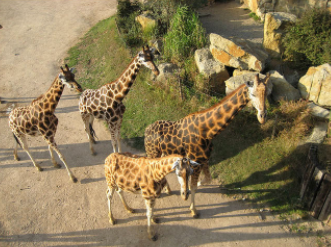

In [13]:
!python sample.py --image='png/example.png'
display_png(Image("png/example.png"))

<start> a dog is sitting on a green grass covered field . <end>


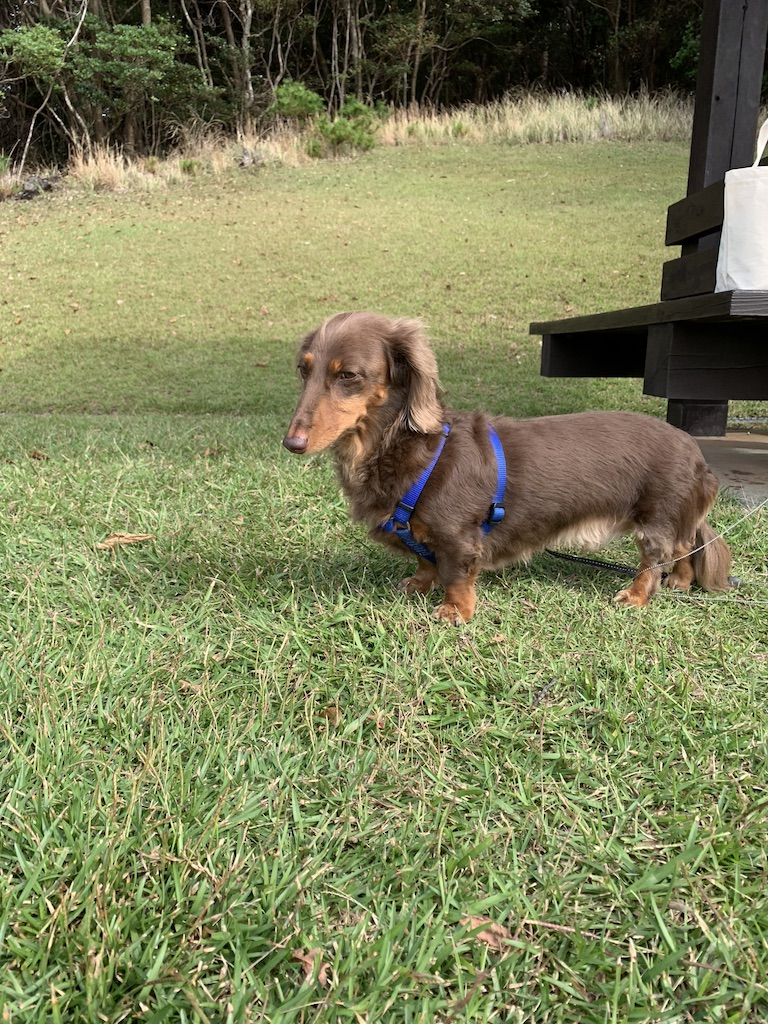

In [20]:
!python sample.py --image='png/fuuga.png'
display_png(Image("png/fuuga.png"))

<start> a man wearing a suit and tie with a tie . <end>


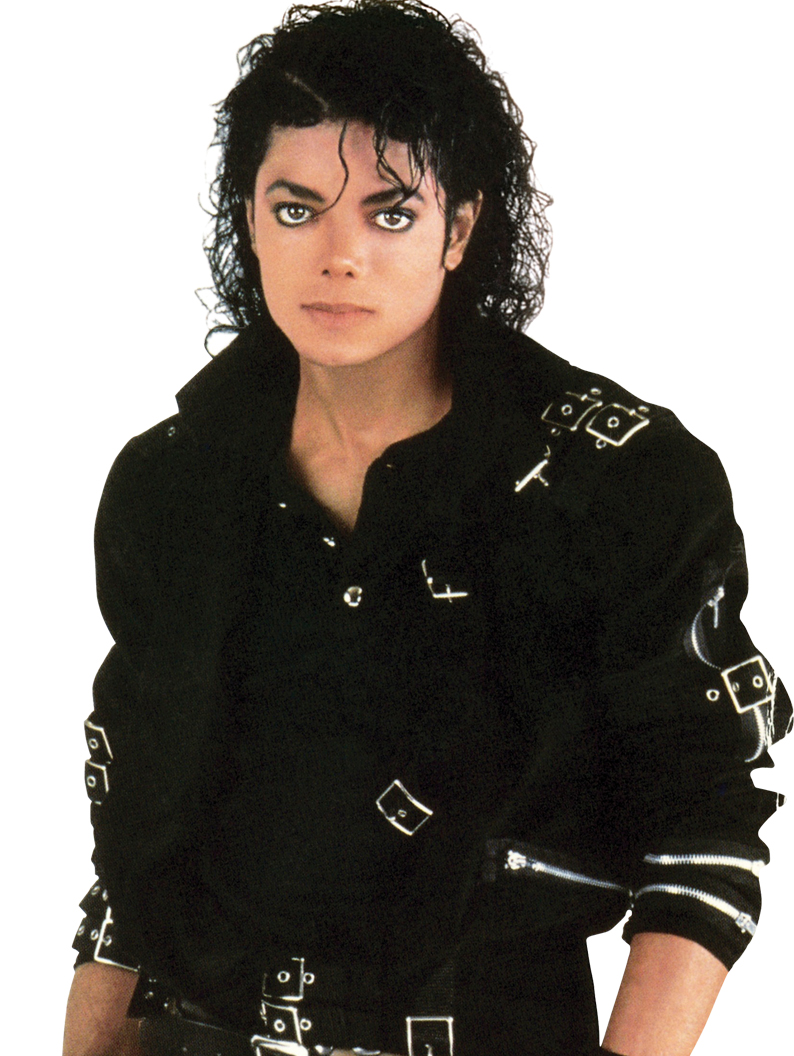

In [28]:
!python sample.py --image='png/a.png'
display_png(Image("png/a.png"))

<start> a man is surfing in the ocean with a surfboard . <end>


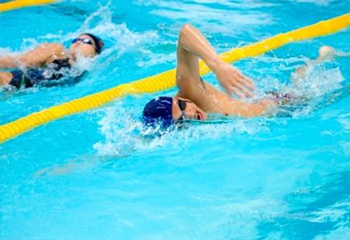

In [31]:
!python sample.py --image='png/swim.png'
display_png(Image("png/swim.png"))

<start> a large clock tower with a clock on it . <end>


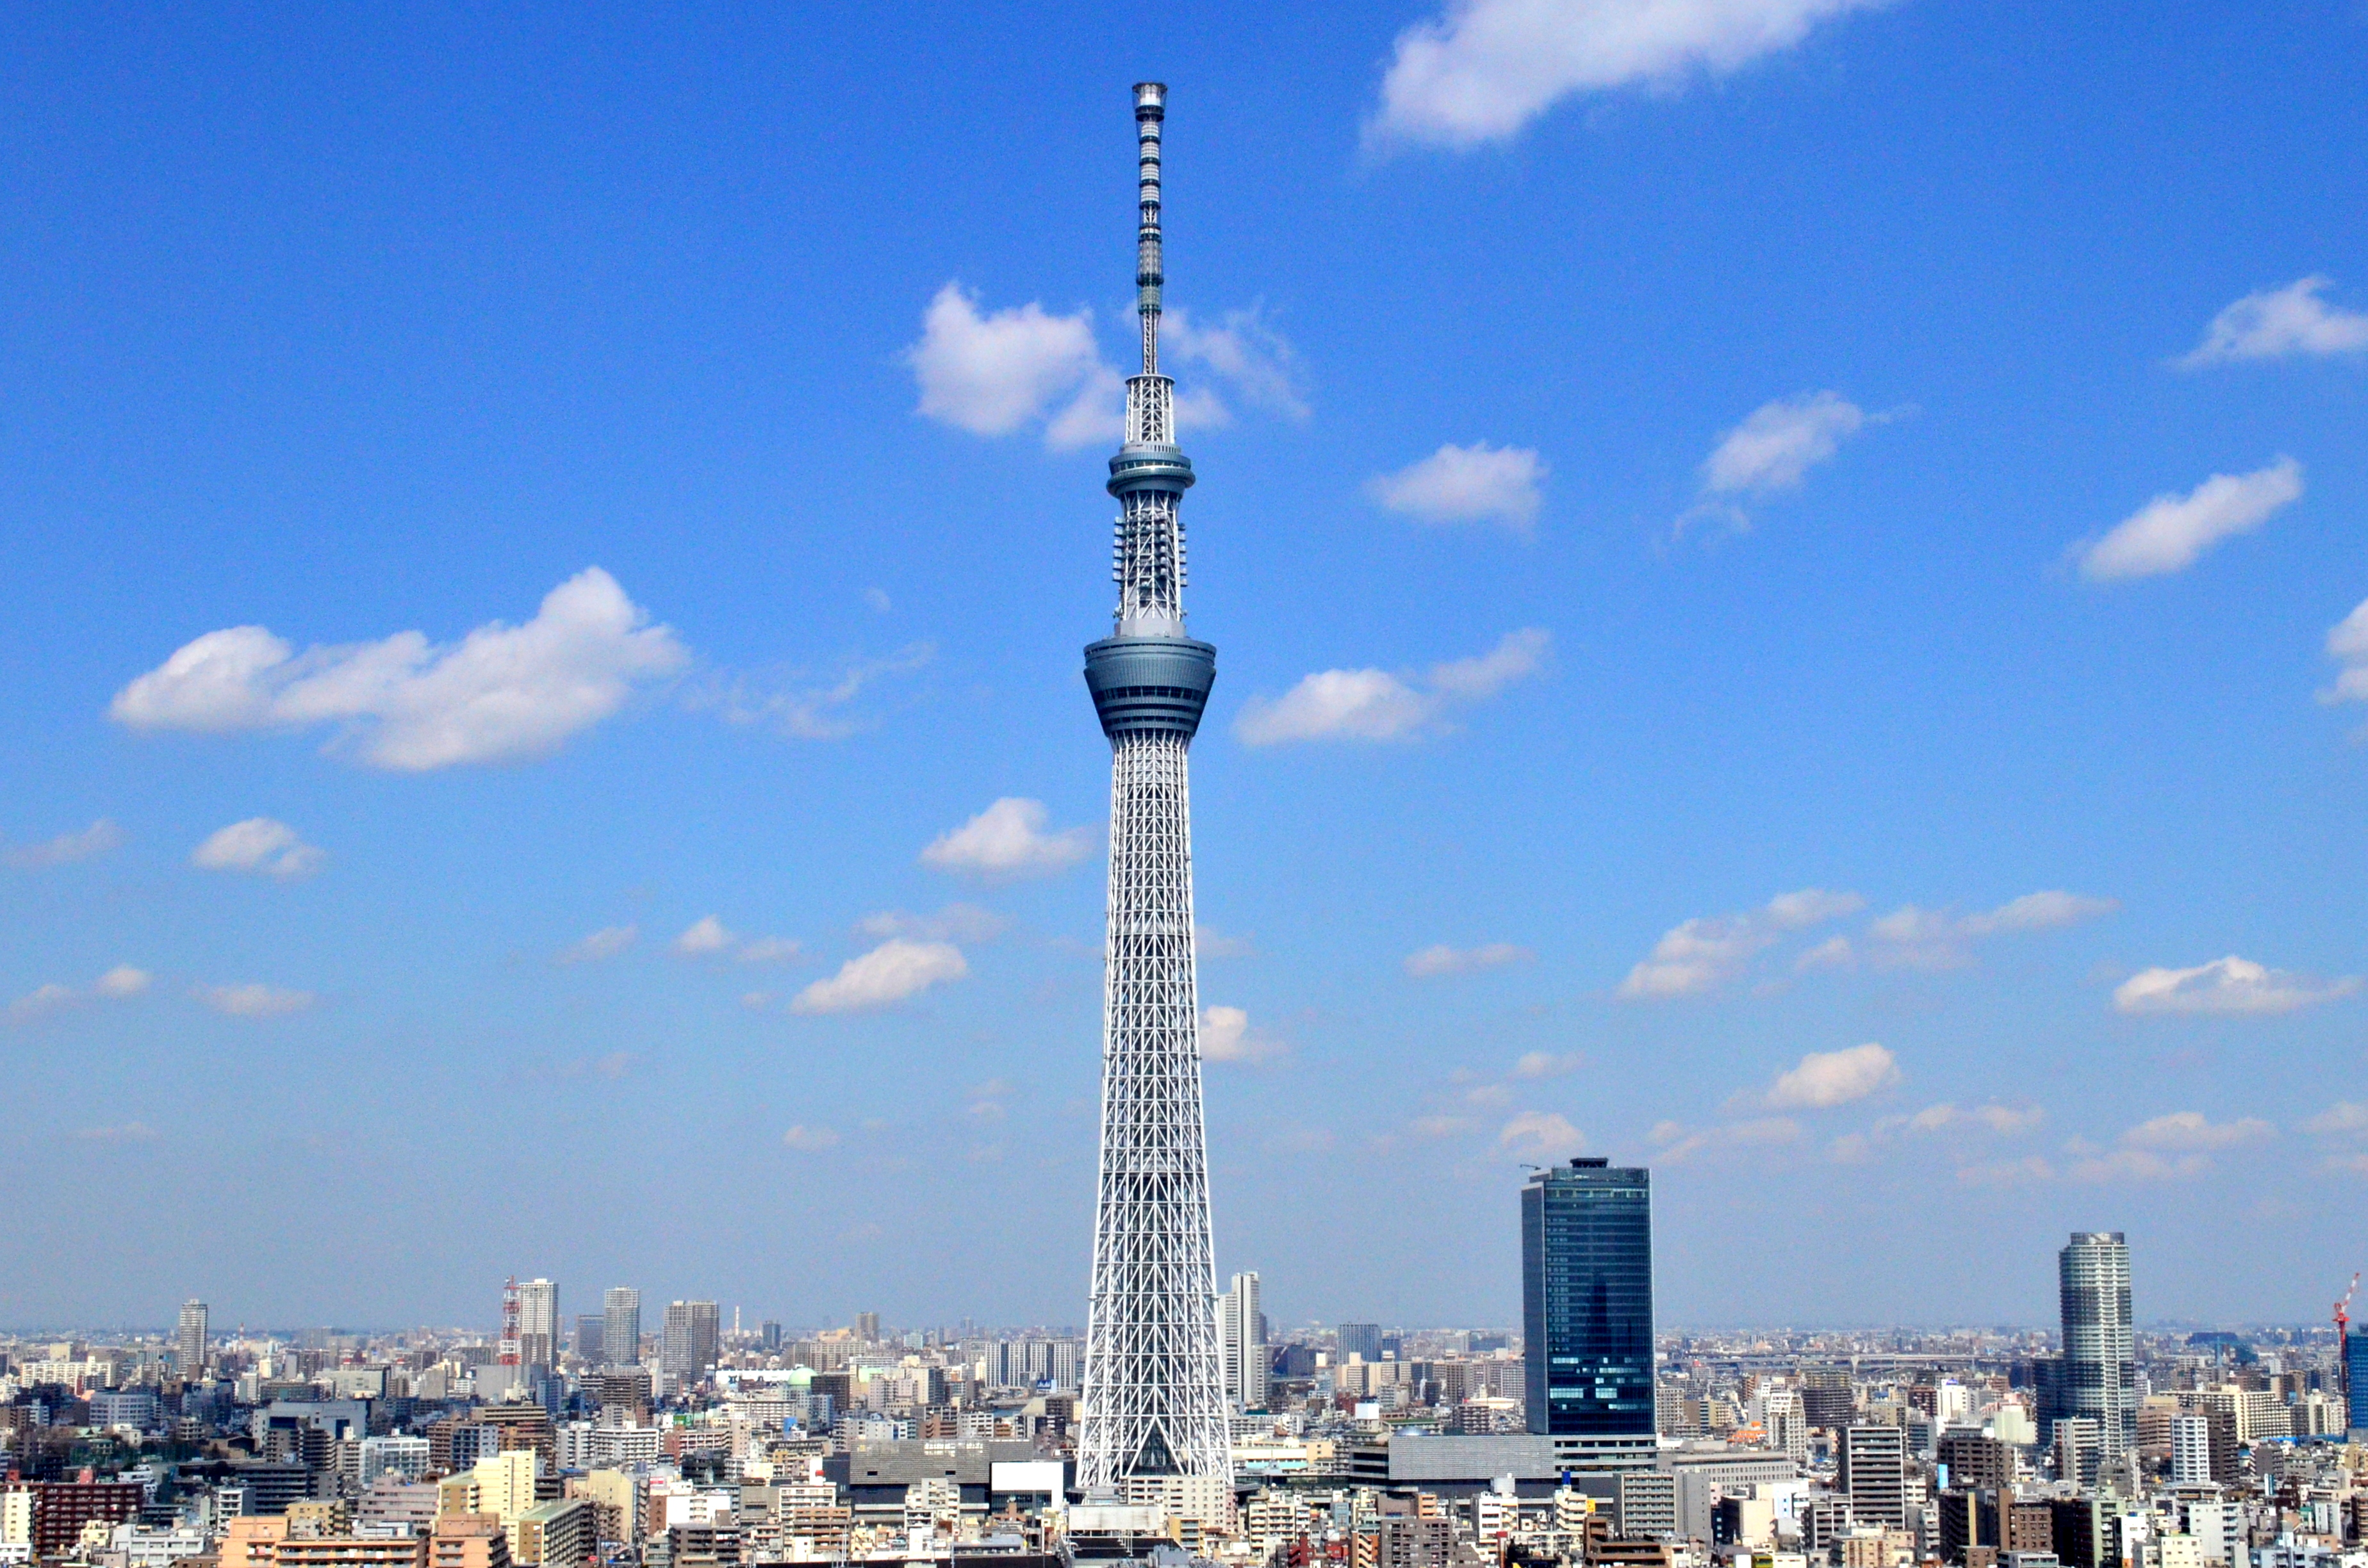

In [32]:
!python sample.py --image='png/skytree.png'
display_png(Image("png/skytree.png"))

## Kerasで動かしたい場合はどうするか
説明

PyTorchによる実装を動かしたが、何らかの理由からKerasで動かしたい状況が考えられる。どういった手順を踏むことになるか調査し、できるだけ詳しく説明せよ。
特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点についてはしっかりと触れること。

**【回答】**  
マイクロソフトのgithubで「MMdnn」という、さまざまなディープラーニングフレームワークの間でユーザーが相互運用するのに役立つツールのセットを公開しています。 例えば。 モデル変換と可視化 Caffe、Keras、MXNet、Tensorflow、CNTK、PyTorch Onnx、およびCoreMLの間でモデルを変換できるようです。  
https://github.com/Microsoft/MMdnn  

こういったツールを利用することも１つの方法だと思いますが、ツールを使わない方法についてはwebで検索を掛けてみましたが見つかりませんでした。

# 5.説明
以下の内容についてJupyter Notebookにまとめる。2日目の夜には自分の言葉で伝えられるようにしておく。

#### ・今回使用したSeq2Seqの実装を使い日本語と英語の翻訳を行いたい場合はどのような手順を踏むか  
**【回答】**  
「ゼロから作るDeppLearning2 -自然言語処理-」の内容を理解することに時間を使ったため、まだこの方法を検討できませんでした。ただ、日本語のテキストファイルを形態素解析などの前処理は必要では無いでしょうか。

<参考>  
日本語から英語への翻訳は、英語から日本語と比較すると翻訳精度はまだ低いようです。特に日本語特有の主語の省略に対応できず、意味の通らない文章になることが多いです。  
https://japan.wipgroup.com/01-translation/machine-translation.html

#### ・機械翻訳のための発展的手法にはどういったものがあるか  
**【回答】**  
Attentionを応用したGNMT（Google Neural Machine Translation）があります。  

<参考>  
NTTコミュニケーションズが「ニューラル機械翻訳（NMT）技術」を使った翻訳サービスを提供しています。
https://www.ntt.com/business/services/application/ai/cotoha-translator.html

#### ・イメージキャプショニングとは逆に文章から画像を生成する手法にはどういったものがあるか  
**【回答】**  
マイクロソフトが開発しているAttentional Generative Adversarial Network（AttnGAN）があるようです。  
http://openaccess.thecvf.com/content_cvpr_2018/papers/Xu_AttnGAN_Fine-Grained_Text_CVPR_2018_paper.pdf

#### ・異なるフレームワークに実装を移す場合にはどういった部分を気をつけるか  
**【回答】**  
引数（sample, width, height, channelなど）はどのフレームワークでも指定する必要があると思いますが、指定する順番が異なるケースがあるので、公式ドキュメントなどを参照して確認する必要があると思います。
